## Google Play (GP) Reviews Sentiment Analysis Using BERT

In this notebook, I compare two models:
- BERT fine-tuned with GP reviews
- BERT fine-tuned with GP reviews with coreferences resolved (CR). (Code for resolving coreference is found in resolving_coreference.ipynb)

Question: Coreference resolution is a difficult task in NLP that has a lot of room to be improved. 
Can modern CR models improve the performance of NLP tasks (sentiment analysis in this case) or will the errors cascade?

In [46]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
%matplotlib inline
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Dataset

the following csv dataset contains original Google Play reviews, as well as CF resolved reviews. Please see resolving_coreference.ipynb for detail


In [2]:
df = pd.read_csv("resolved_reviews.csv")

1-5 star ratings are converted into three classes: Negative (1-2) Neutral (3) Positive (4-5)

In [3]:
def to_sentiment(rating):
    rating = int(rating)
    if rating <= 2:
        return 0
    elif rating == 3:
        return 1
    else: 
        return 2

df['sentiment'] = df.score.apply(to_sentiment)

Distribution of the dataset

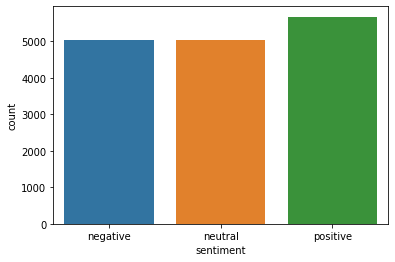

In [28]:
classes = ['negative', 'neutral', 'positive']
ax = sns.countplot(df.sentiment)
plt.xlabel('sentiment')
ax.set_xticklabels(classes);

In [8]:
df.drop(df.columns.difference(['content','coref_resolved_content', 'sentiment']), 1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15746 entries, 0 to 15745
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   content                 15746 non-null  object
 1   coref_resolved_content  15746 non-null  object
 2   sentiment               15746 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 369.2+ KB


In [9]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [10]:
MAX_LEN = 160

In [11]:
class GPReviewDataset(Dataset):

    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
        review,
        add_special_tokens=True,
        max_length=self.max_len,
        return_token_type_ids=False,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt',
        )

        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }

In [12]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

Dataloader for original reviews

In [32]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        reviews=df.content.to_numpy(),
        targets=df.sentiment.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )

    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=4
    )

BATCH_SIZE = 16
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

Dataloader for CR reviews

In [13]:
def create_data_loader2(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        reviews=df.coref_resolved_content.to_numpy(),
        targets=df.sentiment.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=4
    )
BATCH_SIZE = 16

train_data_loader2 = create_data_loader2(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader2 = create_data_loader2(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader2 = create_data_loader2(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

## BERT MODEL

In [14]:
bert_model = BertModel.from_pretrained('bert-base-cased', return_dict=False)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [15]:
class SentimentClassifier(nn.Module):

    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-cased', return_dict=False)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask
        )
        output = self.drop(pooled_output)
        return self.out(output)

In [29]:
model = SentimentClassifier(len(classes))
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## NOTE: I trained and saved the model on google colab because it is too slow on jupyter.

In [88]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
#HERE, change train_data_loader to train_data_loader2 if you want to train with the CR reviews. 
total_steps = len(train_data_loader) * EPOCHS 

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [25]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
    model = model.train()

    losses = []
    correct_predictions = 0

    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)

        outputs = model(
          input_ids=input_ids,
          attention_mask=attention_mask
    )

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

In [26]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,    
        loss_fn, 
        optimizer, 
        device, 
        scheduler, 
        len(df_train)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn, 
        device, 
        len(df_val)
    )

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'base_best_model_state.bin') #'coref_best_model_state.bin' 
        best_accuracy = val_acc

## Saved models
You can just load the models that I trained and saved.
- base_best_model_state.bin --> trained with original reviews
- coref_best_model_state.bin --> trained with CR reviews

In [89]:
model = SentimentClassifier(len(classes))
model.load_state_dict(torch.load('base_best_model_state.bin', map_location ='cpu'))
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [33]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)
test_acc.item()

[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs

0.8743654822335025

In [35]:
model2 = SentimentClassifier(len(classes))
model2.load_state_dict(torch.load('coref_best_model_state.bin', map_location ='cpu'))
model2 = model2.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [36]:
test_acc, _ = eval_model(
  model2,
  test_data_loader2,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs

0.8946700507614214

## Evaluation
The raw accuracy of the C resolved model is 2% higher than the model built with original dataset. 
Let's take a deeper look. 

In [52]:
def get_predictions(model, data_loader):
    model = model.eval()

    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:

            texts = d["review_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            probs = F.softmax(outputs, dim=1)

            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return review_texts, predictions, prediction_probs, real_values


In [57]:
#ORIGINAL 
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)
print(classification_report(y_test, y_pred, target_names=classes))

#COREFERENCE RESOLVED
y_review_texts2, y_pred2, y_pred_probs2, y_test2 = get_predictions(
  model2,
  test_data_loader2
)
print(classification_report(y_test2, y_pred2, target_names=classes))



Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

              precision    recall  f1-score   support

    negative       0.92      0.82      0.87       245
     neutral       0.79      0.88      0.83       254
    positive       0.92      0.91      0.92       289

    accuracy                           0.87       788
   macro avg       0.88      0.87      0.87       788
weighted avg       0.88      0.87      0.88       788



Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

              precision    recall  f1-score   support

    negative       0.93      0.87      0.90       245
     neutral       0.83      0.87      0.85       254
    positive       0.92      0.94      0.93       289

    accuracy                           0.89       788
   macro avg       0.90      0.89      0.89       788
weighted avg       0.90      0.89      0.89       788



The model tuned with CR reviews have higher accuracy and recall as well. 
Check the confusion matrix below

Text(0.5, 1.0, 'Original Model')

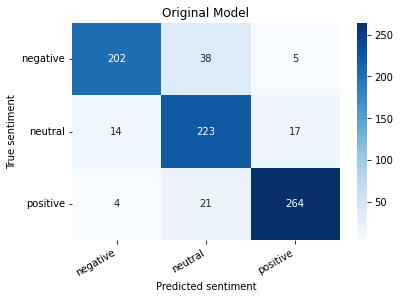

In [92]:
cm = confusion_matrix(y_test, y_pred)
orig_cm = pd.DataFrame(cm, index=classes, columns=classes)

hmap = sns.heatmap(orig_cm, annot=True, fmt="d", cmap="Blues")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True sentiment')
plt.xlabel('Predicted sentiment');
plt.title("Original Model")

Text(0.5, 1.0, 'Coreference Resolved Model')

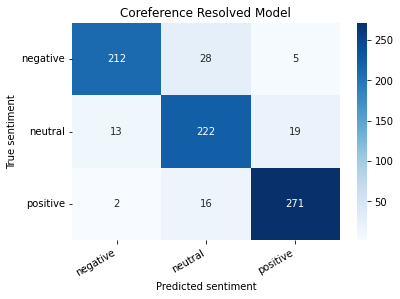

In [93]:
cm2 = confusion_matrix(y_test2, y_pred2)
cr_cm = pd.DataFrame(cm2, index=classes, columns=classes)
hmap = sns.heatmap(cr_cm, annot=True, fmt="d", cmap="Blues")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True sentiment')
plt.xlabel('Predicted sentiment');
plt.title("Coreference Resolved Model")

The original model misclassified many of negative or positive reviews as netural. CR model had the greatest improvement in that area. 

# Checking out examples from test set

In [102]:
wrong_indices = []
for i in range(len(y_test)):
    if int(y_pred[i]) != int(y_test[i]):
        wrong_indices.append(i)
        
print("Original Model made", len(wrong_indices), "Incorrect Predictions on the following data:")
print(wrong_indices)

99 Incorrect Predictions on the following data:
[0, 4, 11, 20, 44, 66, 81, 96, 102, 103, 115, 123, 124, 135, 137, 141, 162, 167, 183, 184, 194, 209, 210, 216, 224, 236, 239, 255, 258, 276, 283, 286, 306, 321, 326, 339, 340, 343, 358, 360, 363, 366, 371, 377, 381, 387, 389, 406, 409, 411, 421, 427, 429, 430, 431, 433, 447, 457, 458, 461, 465, 475, 481, 483, 494, 498, 499, 505, 522, 528, 543, 544, 548, 565, 577, 579, 585, 603, 610, 616, 628, 644, 656, 675, 677, 680, 688, 710, 712, 720, 731, 732, 755, 756, 765, 770, 775, 778, 784]


In [106]:
wrong_indices2 = []
for i in range(len(y_test2)):
    if int(y_pred2[i]) != int(y_test2[i]):
        wrong_indices2.append(i)
        
print("CR Model made", len(wrong_indices2), "Incorrect Predictions on the following data:")
print(wrong_indices2)

CR Model made 83 Incorrect Predictions on the following data:
[4, 20, 39, 44, 66, 71, 91, 102, 115, 123, 137, 141, 148, 162, 177, 183, 184, 194, 216, 220, 227, 235, 239, 264, 276, 286, 306, 321, 323, 326, 331, 340, 358, 360, 363, 366, 377, 381, 387, 389, 394, 406, 409, 411, 427, 429, 430, 431, 447, 457, 458, 461, 475, 479, 483, 505, 528, 543, 548, 565, 569, 577, 596, 603, 610, 628, 644, 652, 655, 675, 677, 680, 686, 710, 720, 727, 731, 732, 739, 755, 770, 775, 778]


In [109]:
print("Examples that the orignal model got wrong but the CR model got right:")
print(list(set(wrong_indices) - set(wrong_indices2)))
print("")
print("Examples that the CR model got wrong but the original model got right:")
print(list(set(wrong_indices2) - set(wrong_indices)))

Examples that the orignal model got wrong but the CR model got right:
[0, 258, 135, 522, 11, 656, 784, 283, 544, 421, 167, 688, 433, 579, 712, 585, 81, 209, 210, 339, 465, 343, 96, 224, 481, 103, 616, 236, 494, 498, 371, 756, 499, 124, 765, 255]

Examples that the CR model got wrong but the original model got right:
[264, 394, 652, 655, 148, 39, 686, 177, 569, 323, 71, 331, 596, 727, 91, 220, 479, 227, 739, 235]


Let's take a look at some of the examples that orignal model got wrong but CR model got right

In [138]:
def sentiment(number):
    if number == 0:
        return "negative"
    elif number == 1:
        return "netural"
    else:
        return "positive"
    
def compare_models(review_index):
    print(y_review_texts[review_index])
    print("\tpredicted:", sentiment(y_pred[review_index]))
    print("\tactual:", sentiment(y_test[review_index]))
    print("")

    print(y_review_texts2[review_index])
    print("\tpredicted:", sentiment(y_pred2[review_index]))
    print("\tactual:", sentiment(y_test2[review_index]))
    print("------------------------")
compare_models(135)
compare_models(96)



I really liked this app, however I have downloaded it yesterday and created tasks which repeats daily but it always shows tasks date 30 March. It was just the date I created it, it repeats daily so the dates should change too. It feels as if I am checking undone tasks from the past. Even in the calander view these tasks are not added to 31 March. It's annoying me. Please do something about it.
	predicted: netural
	actual: positive

I really liked this app, however I have downloaded this app yesterday and created tasks which repeats daily but this app always shows tasks date 30 March. 30 March was just the date I created this app, this app repeats daily so the dates should change too. It feels as if I am checking undone tasks from the past. Even in the calander view tasks which repeats daily are not added to 31 March. It's annoying me. Please do something about it.
	predicted: positive
	actual: positive
------------------------
Even though you don't get full access for free, this app st

In both of these examples, the word "it" is resolved to the word "this app". The object of attention ("this app") is referenced acrossed the review in the CR version.

Let's take a look at some of the examples that CR model got wrong but original model got right.

In [141]:
compare_models(264)
compare_models(652)

Drains a heck lot of battery
	predicted: negative
	actual: negative

Drains a heck lot of battery
	predicted: netural
	actual: negative
------------------------
i want to love this app but lately after once i open this app, then the second time i want to open it, it just doesnt open i dont know why, so i need to keep uninstall and reinstall back and it annoyed me
	predicted: negative
	actual: negative

i want to love this app but lately after once i open this app, then the second time i want to open this app, this app just doesnt open i dont know why, so i need to keep uninstall and reinstall back and it annoyed me
	predicted: netural
	actual: negative
------------------------


## Conclusion
Based on the quantitative results, it is clear the coreference resolved model performed better in all metric. However, there isn't any qualitative interpretation that I can think of that provides a convincing argument. For instance, some of the review examples that had no coreferences to be resolved were predicted differently by the two models. This is an area that I will explore more in the future.